<a href="https://colab.research.google.com/github/rahulpandeycs/CS5100-COVID19-AI-PROJECT/blob/master/CS5100_COVID19_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, I/O for CSV files
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import datetime as dt
from datetime import date
import warnings

View the list of input data

In [2]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
warnings.filterwarnings('ignore')

data/time_series_covid_19_deaths.csv
data/time_series_covid_19_confirmed.csv
data/COVID19_open_line_list.csv
data/covid_19_data.csv
data/COVID19_line_list_data.csv
data/time_series_covid_19_recovered.csv


Dropping unnecessary columns

In [0]:
Y2019_dataset_path = 'data/covid_19_data.csv'
Y2019_data = pd.read_csv(Y2019_dataset_path)

Preprocessing data

In [4]:
Y2019_data['Last Update'] = pd.to_datetime(Y2019_data['Last Update'])
Y2019_data['Outbreak'] = 'COVID-19'
Y2019_data.drop(['SNo'], axis = 1, inplace = True)
Y2019_data.tail()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Outbreak
9730,03/28/2020,Wyoming,US,2020-03-28 23:11:06,82.0,0.0,0.0,COVID-19
9731,03/28/2020,Xinjiang,Mainland China,2020-03-28 23:11:06,76.0,3.0,73.0,COVID-19
9732,03/28/2020,Yukon,Canada,2020-03-28 23:11:06,4.0,0.0,0.0,COVID-19
9733,03/28/2020,Yunnan,Mainland China,2020-03-28 23:11:06,180.0,2.0,172.0,COVID-19
9734,03/28/2020,Zhejiang,Mainland China,2020-03-28 23:11:06,1251.0,1.0,1225.0,COVID-19


Feature Engineering: Imputation (Numerical and Categorical), Encoding, Scaling, Normalization, Log Transform*, 

In [0]:
#Numerical Imputation
Y2019_data['Confirmed'] = Y2019_data['Confirmed'].fillna(0)
#Filling missing values with medians of the columns, not relevant here
#data = data.fillna(data.median())

#Categorical Imputation
Y2019_data['Province/State'] = Y2019_data['Province/State'].fillna('others')

#Max fill function for categorical columns, not relevant here
#data['column_name'].fillna(data['column_name'].value_counts().idxmax(), inplace=True)

Y2019_data = Y2019_data.sort_values(['Country/Region', 'Province/State','Last Update'])

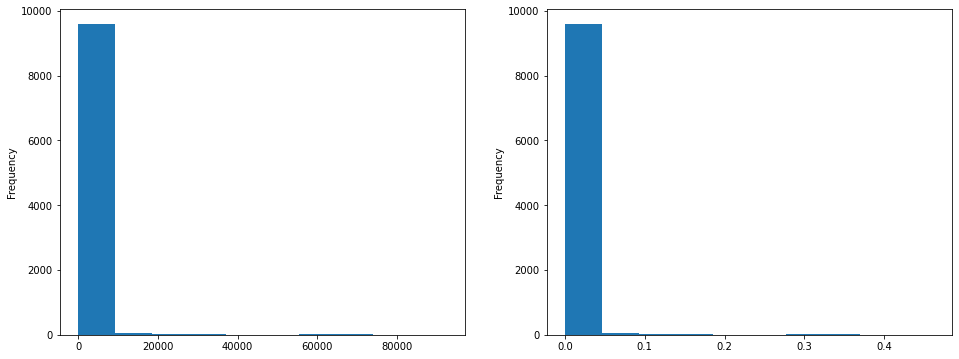

In [6]:
# Rename items

fix, ax = plt.subplots(figsize=(16,6), ncols=2)
s0 = Y2019_data['Confirmed']
s0.plot.hist(ax=ax[0])

# BoxCox
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='box-cox', standardize=True)
s0 = s0+1

# Normalise and reshape
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0,1)).fit(np.asarray([0, 2E5]).reshape(-1,1)) # df['Confirmed'].values.reshape(-1,1)

s1 = pd.Series(transformer.transform(s0.values.reshape(-1,1)).reshape(-1))
s1.plot.hist(ax=ax[1])
Y2019_data['Confirmed_transformed'] = s1 # make sure that every value is positive

In [0]:
Y2019_data['Month'] = Y2019_data['Last Update'].dt.month
Y2019_data['Week'] = Y2019_data['Last Update'].dt.week

Label Encoding

In [0]:
from sklearn.preprocessing import LabelEncoder
outbreak_Encode = LabelEncoder().fit(Y2019_data['Outbreak'])
Y2019_data['Outbreak_Encode'] = outbreak_Encode.transform(Y2019_data['Outbreak'])

country_Encode = LabelEncoder().fit(Y2019_data['Country/Region'])
Y2019_data['Country_Encode'] = country_Encode.transform(Y2019_data['Country/Region'])

List of affected countries:

In [9]:
listOfCountries = Y2019_data['Country/Region'].unique().tolist()
print("\n Number of countries affected by COVID-19 virus: ", len(listOfCountries))
print(listOfCountries)


 Number of countries affected by COVID-19 virus:  212
[' Azerbaijan', "('St. Martin',)", 'Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia', 'Ga

In [10]:
Y2019_China = Y2019_data.loc[Y2019_data['Country/Region'] == 'Mainland China']
Y2019_data.tail()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Outbreak,Confirmed_transformed,Month,Week,Outbreak_Encode,Country_Encode
5152,03/12/2020,others,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,COVID-19,0.000625,3,11,0,211
5631,03/14/2020,others,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,COVID-19,0.000065,3,11,0,211
5889,03/15/2020,others,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,COVID-19,0.021025,3,11,0,211
6161,03/16/2020,others,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,COVID-19,0.000085,3,11,0,211
6437,03/17/2020,others,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,COVID-19,0.000015,3,11,0,211


Lets start by looking at data by regions: China

In [11]:
# Y2019_data_new = Y2019_data[Y2019_data['Last Update'] > pd.Timestamp(date(2020,2,15))] //Not needed now
Y2019_data_new = Y2019_data
Y2019_data_new.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Outbreak,Confirmed_transformed,Month,Week,Outbreak_Encode,Country_Encode
2663,02/28/2020,others,Azerbaijan,2020-02-28 15:03:26,1.0,0.0,0.0,COVID-19,0.000200,2,9,0,0
4674,03/10/2020,others,"('St. Martin',)",2020-03-10 05:33:02,2.0,0.0,0.0,COVID-19,0.000220,3,11,0,1
2258,02/24/2020,others,Afghanistan,2020-02-24 23:33:02,1.0,0.0,0.0,COVID-19,0.000055,2,9,0,2
2351,02/25/2020,others,Afghanistan,2020-02-24 23:33:02,1.0,0.0,0.0,COVID-19,0.000955,2,9,0,2
2452,02/26/2020,others,Afghanistan,2020-02-24 23:33:02,1.0,0.0,0.0,COVID-19,0.000030,2,9,0,2


Creating a dataframe for Region: Italy

In [12]:
dataFrame = pd.DataFrame(Y2019_data_new)
dataFrame = dataFrame.loc[dataFrame['Country/Region'] == 'Italy']
dataFrame.tail()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Outbreak,Confirmed_transformed,Month,Week,Outbreak_Encode,Country_Encode
8285,03/24/2020,others,Italy,2020-03-24 23:41:50,69176.0,6820.0,8326.0,COVID-19,0.000010,3,13,0,98
8586,03/25/2020,others,Italy,2020-03-25 23:37:49,74386.0,7503.0,9362.0,COVID-19,0.000420,3,13,0,98
8888,03/26/2020,others,Italy,2020-03-26 23:53:24,80589.0,8215.0,10361.0,COVID-19,0.000015,3,13,0,98
9195,03/27/2020,others,Italy,2020-03-27 23:27:48,86498.0,9134.0,10950.0,COVID-19,0.000010,3,13,0,98
9502,03/28/2020,others,Italy,2020-03-28 23:11:06,92472.0,10023.0,12384.0,COVID-19,0.000075,3,13,0,98


In [0]:
newConfirmed = [0]
newDeaths = [0]
newRecovered = [0]
for data in range(1, (dataFrame.Confirmed).size): 
    newConfirmed.append(dataFrame.Confirmed.tolist()[data]-dataFrame.Confirmed.tolist()[data-1])
    newDeaths.append(dataFrame.Deaths.tolist()[data]-dataFrame.Deaths.tolist()[data-1])
    newRecovered.append(dataFrame.Recovered.tolist()[data]-dataFrame.Recovered.tolist()[data-1])


Using TensorFlow Backend for prediction of deaths and number of confirmed cases

In [0]:
from numpy import array
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.backend import clear_session

In [0]:
def format_sequence(sequence, n_steps):
    X, Y = list(), list()
    for data in range(len(sequence)):
      end_datax = data + n_steps #End of this pattern
      if end_datax > len(sequence) - 1:
        break  # break if we went beyond the sequence
      seqX, seqY = sequence[data: end_datax], sequence[end_datax]
      X.append(seqX)
      Y.append(seqY)
    return array(X), array(Y)    

In [0]:
unformattedSequence = np.array(newConfirmed)
nSteps = 5
X, Y = format_sequence(unformattedSequence, nSteps)


nFeatures = 1
X = X.reshape((X.shape[0], X.shape[1], nFeatures))

Define model and adding neural network layers

Trying LSTM with **linear** activation function

In [17]:
LSTMModel = Sequential()
LSTMModel.add(LSTM(50, activation='linear', return_sequences=True, input_shape = (nSteps, nFeatures)))
LSTMModel.add(Dropout(0.1))
LSTMModel.add(LSTM(50, activation='linear', return_sequences=True))
LSTMModel.add(Dropout(0.1))
LSTMModel.add(LSTM(50, activation='linear'))
LSTMModel.add(Dense(1))

#Added two LSTM layers

start = time.time()
LSTMModel.compile(optimizer='adam', loss='mse')
print('Compilation time :', time.time() - start)
print('\n')
LSTMModel.summary()

Compilation time : 0.010835886001586914


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
__________

In [18]:
LSTMModel.fit(X,Y, epochs=300, verbose= 0)
xInput = np.array(newConfirmed)[-nSteps:]
xInput = xInput.reshape((1, nSteps, nFeatures))
yHat =LSTMModel.predict(xInput, verbose=0)

forecastedCases = int(round(yHat[0][0]))
print('Case forecast for today: {}'.format(forecastedCases))

predictionAccuracy = 100*(1-np.abs(forecastedCases - newConfirmed[-1])/newConfirmed[-1])
print('Prediction accuracy: {:.2f} %'.format(predictionAccuracy))

Case forecast for today: 7239
Prediction accuracy: 78.82 %


In [20]:
xinput2 = np.array(newConfirmed)[(-nSteps+1):]
xinput2 = np.concatenate((xinput2, yHat), axis=None)
xinput2 = xinput2.reshape((1, nSteps, nFeatures))
yhat2 = LSTMModel.predict(xinput2, verbose=0)
print('Number of cases for tomorrow {:.0f}'.format(int(yhat2[0][0])))

Number of cases for tomorrow 6435


Trying LSTM with Relu activation function

In [21]:
clear_session()

LSTMModel_Relu = Sequential()
LSTMModel_Relu.add(LSTM(50, activation='relu', return_sequences=True, input_shape = (nSteps, nFeatures)))
LSTMModel_Relu.add(Dropout(0.1))
LSTMModel_Relu.add(LSTM(50, activation='relu', return_sequences=True))
LSTMModel_Relu.add(Dropout(0.1))
LSTMModel_Relu.add(LSTM(50, activation='relu'))
LSTMModel_Relu.add(Dense(1))

#Added two LSTM layers

start = time.time()
LSTMModel_Relu.compile(optimizer='adam', loss='mse')
print('Compilation time :', time.time() - start)
print('\n')
LSTMModel_Relu.summary()

Compilation time : 0.005916118621826172


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
__________

In [22]:
LSTMModel_Relu.fit(X,Y, epochs=300, verbose= 0)
xInput_Relu = np.array(newConfirmed)[-nSteps:]
xInput_Relu = xInput_Relu.reshape((1, nSteps, nFeatures))
yHat_Relu =LSTMModel_Relu.predict(xInput_Relu, verbose=0)

forecastedCases_Relu = int(round(yHat_Relu[0][0]))
print('Case forecast for today: {}'.format(forecastedCases_Relu))

predictionAccuracy_relu = 100*(1-np.abs(forecastedCases_Relu - newConfirmed[-1])/newConfirmed[-1])
print('Prediction accuracy: {:.2f} %'.format(predictionAccuracy_relu))

Case forecast for today: 6586
Prediction accuracy: 89.76 %


Tomorrow forecast

In [23]:
xinput2_relu = np.array(newConfirmed)[(-nSteps+1):]
xinput2_relu = np.concatenate((xinput2_relu, yHat), axis=None)
xinput2_relu = xinput2_relu.reshape((1, nSteps, nFeatures))
yhat2_relu = LSTMModel_Relu.predict(xinput2_relu, verbose=0)
print('Number of cases for tomorrow {:.0f}'.format(int(yhat2_relu[0][0])))

Number of cases for tomorrow 6648


Prediction for number of deaths

In [0]:
rawSequence = np.array(newDeaths)
nSteps = 4
X, Y = format_sequence(rawSequence, nSteps)

nFeatures = 1
X = X.reshape((X.shape[0], X.shape[1], nFeatures))

Deaths Prediction

Using LSTM Linear activation function

In [25]:
#Model
LSTMModel2 = Sequential()
LSTMModel2.add(LSTM(50, activation = 'linear', return_sequences=True, input_shape= (nSteps, nFeatures)))
LSTMModel2.add(LSTM(50, activation='linear', return_sequences=True))
LSTMModel2.add(LSTM(50, activation= 'linear'))
LSTMModel2.add(Dense(1))

currentTime = time.time()
LSTMModel2.compile(optimizer = 'adam', loss='mse')
LSTMModel2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 50)             10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
LSTMModel2.fit(X, Y, epochs=300, verbose=0)

xInput = np.array(newDeaths)[-nSteps:]
xInput = xInput.reshape((1, nSteps, nFeatures))
yHat2 = LSTMModel2.predict(xInput, verbose=0)

deathPrediction = int(round(yHat2[0][0]))
print('Deaths prediction for today: {}'.format(deathPrediction))

predictionAccuracy = 100*(1-np.abs(deathPrediction - newDeaths[-1])/newDeaths[-1])
print('Prediction accuracy: {:.2f} %'.format(predictionAccuracy))

Deaths prediction for today: 932
Prediction accuracy: 95.16 %


In [27]:
xInput2 = np.array(newDeaths)[(-nSteps+1):]
xInput2 = np.concatenate((xInput2, yHat2), axis=None)
xInput2 = xInput2.reshape((1, nSteps, nFeatures))
yHat3 = LSTMModel2.predict(xInput2, verbose=0)
print('There might be {:.0f} deaths tomorrow'.format(int(yHat3[0][0])))

There might be 789 deaths tomorrow


Using LSTM Relu activation function

In [28]:
#Model
LSTMModel2_relu = Sequential()
LSTMModel2_relu.add(LSTM(50, activation = 'relu', return_sequences=True, input_shape= (nSteps, nFeatures)))
LSTMModel2_relu.add(LSTM(50, activation='relu', return_sequences=True))
LSTMModel2_relu.add(LSTM(50, activation= 'relu'))
LSTMModel2_relu.add(Dense(1))

currentTime = time.time()
LSTMModel2_relu.compile(optimizer = 'adam', loss='mse')
LSTMModel2_relu.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 50)             10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
LSTMModel2_relu.fit(X, Y, epochs=300, verbose=0)

xInput_relu = np.array(newDeaths)[-nSteps:]
xInput_relu = xInput_relu.reshape((1, nSteps, nFeatures))
yHat2_relu = LSTMModel2_relu.predict(xInput_relu, verbose=0)

deathPrediction_relu = int(round(yHat2_relu[0][0]))
print('Deaths prediction for today: {}'.format(deathPrediction_relu))

death_predictionAccuracy_relu = 100*(1-np.abs(deathPrediction_relu - newDeaths[-1])/newDeaths[-1])
print('Prediction accuracy: {:.2f} %'.format(death_predictionAccuracy_relu))

Deaths prediction for today: 881
Prediction accuracy: 99.10 %


In [30]:
xInput2_relu = np.array(newDeaths)[(-nSteps+1):]
xInput2_relu = np.concatenate((xInput2_relu, yHat2), axis=None)
xInput2_relu = xInput2_relu.reshape((1, nSteps, nFeatures))
yHat3_relu = LSTMModel2_relu.predict(xInput2_relu, verbose=0)
print('There might be {:.0f} deaths tomorrow'.format(int(yHat3_relu[0][0])))

There might be 832 deaths tomorrow
